<a href="https://colab.research.google.com/github/softmurata/colab_notebooks/blob/main/inpainting/inpainting%2Bpropermask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install diffusers transformers accelerate scipy safetensors xformers

In [ ]:
import torch
from PIL import Image
import cv2
from diffusers import StableDiffusionInpaintPipeline
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    # torch_dtype=torch.float16,
).to("cuda")
pipe.enable_attention_slicing()

In [9]:
input_image = Image.open("/content/room003.jpeg")
bh, bw = input_image.size

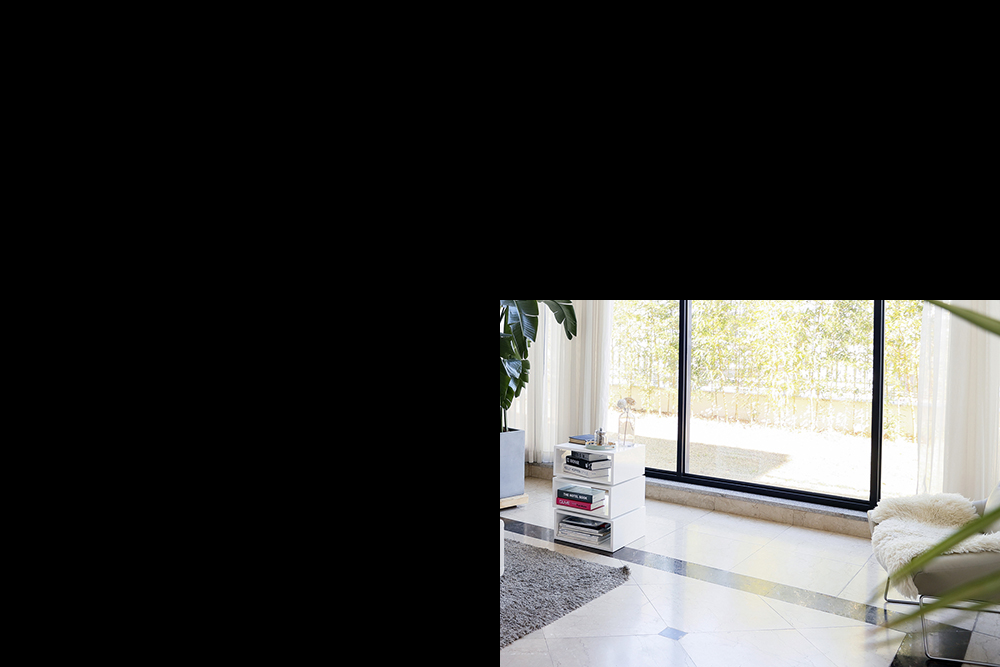

In [10]:
import numpy as np
x = 500
y = 300
w = h = 500

img = np.asarray(input_image)
mask = np.zeros(img.shape[:2],np.uint8)
mask[y:y+h,x:x+w] = 255
res = cv2.bitwise_and(img,img,mask = mask)
mask_image = Image.fromarray(mask)
display(Image.fromarray(res))

In [11]:
input_image = input_image.resize((512, 512))
mask_image = mask_image.resize((512, 512))

  0%|          | 0/50 [00:00<?, ?it/s]

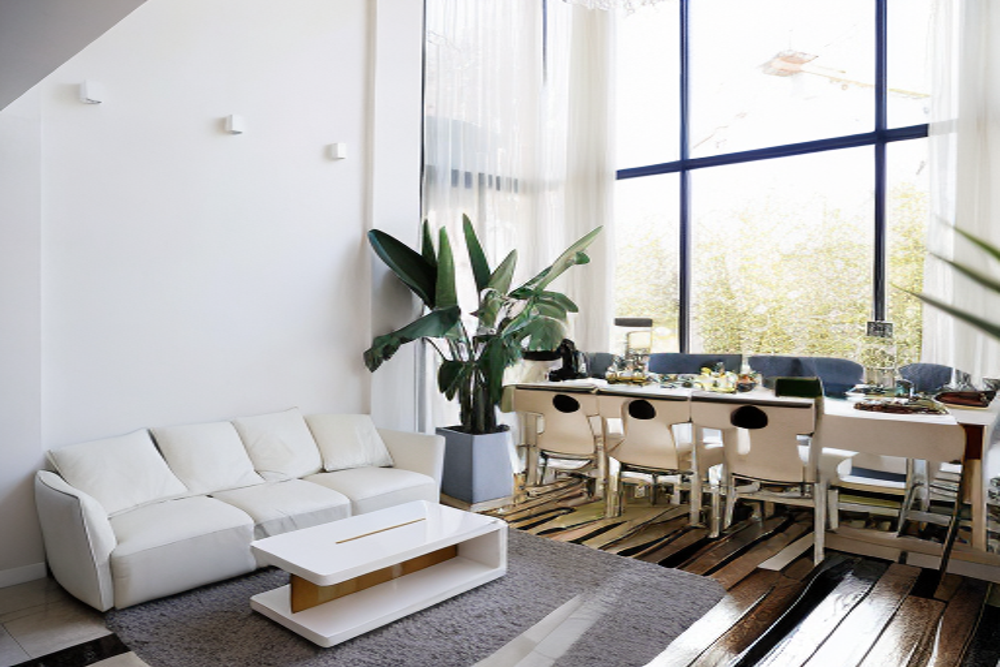

In [13]:
prompt = "add 1 dining table, 2 chairs"
#image and mask_image should be PIL images.
#The mask structure is white for inpainting and black for keeping as is
image = pipe(prompt=prompt, image=input_image, mask_image=mask_image).images[0]
display(image.resize((bh, bw)))

In [ ]:
!pip install gradio diffusers transformers

In [ ]:
!pip install accelerate

In [5]:
# Drawable stable diffusion inpainting
import gradio as gr
#test
from io import BytesIO
import requests
import PIL
from PIL import Image
import numpy as np
import os
import uuid
import torch
from torch import autocast
import cv2
from matplotlib import pyplot as plt
from diffusers import DiffusionPipeline
from torchvision import transforms

# auth_token = os.environ.get("API_TOKEN") or True

def download_image(url):
    response = requests.get(url)
    return PIL.Image.open(BytesIO(response.content)).convert("RGB")

device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = DiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    revision="fp16", 
    torch_dtype=torch.float16,
).to(device)

transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
      transforms.Resize((512, 512)),
])

def predict(dict, prompt=""):
    with autocast("cuda"):
      init_image = dict["image"].convert("RGB").resize((512, 512))
      mask = dict["mask"].convert("RGB").resize((512, 512))
    #with autocast("cuda"):
    output = pipe(prompt = prompt, image=init_image, mask_image=mask)
    return output.images[0]

# examples = [[dict(image="init_image.png", mask="mask_image.png"), "A panda sitting on a bench"]]
css = '''
.container {max-width: 1150px;margin: auto;padding-top: 1.5rem}
#image_upload{min-height:400px}
#image_upload [data-testid="image"], #image_upload [data-testid="image"] > div{min-height: 400px}
#mask_radio .gr-form{background:transparent; border: none}
#word_mask{margin-top: .75em !important}
#word_mask textarea:disabled{opacity: 0.3}
.footer {margin-bottom: 45px;margin-top: 35px;text-align: center;border-bottom: 1px solid #e5e5e5}
.footer>p {font-size: .8rem; display: inline-block; padding: 0 10px;transform: translateY(10px);background: white}
.dark .footer {border-color: #303030}
.dark .footer>p {background: #0b0f19}
.acknowledgments h4{margin: 1.25em 0 .25em 0;font-weight: bold;font-size: 115%}
#image_upload .touch-none{display: flex}
'''


image_blocks = gr.Blocks(css=css)
with image_blocks as demo:
    gr.HTML(
        """
            <div style="text-align: center; max-width: 650px; margin: 0 auto;">
              <div
                style="
                  display: inline-flex;
                  align-items: center;
                  gap: 0.8rem;
                  font-size: 1.75rem;
                "
              >
                <svg
                  width="0.65em"
                  height="0.65em"
                  viewBox="0 0 115 115"
                  fill="none"
                  xmlns="http://www.w3.org/2000/svg"
                >
                  <rect width="23" height="23" fill="white"></rect>
                  <rect y="69" width="23" height="23" fill="white"></rect>
                  <rect x="23" width="23" height="23" fill="#AEAEAE"></rect>
                  <rect x="23" y="69" width="23" height="23" fill="#AEAEAE"></rect>
                  <rect x="46" width="23" height="23" fill="white"></rect>
                  <rect x="46" y="69" width="23" height="23" fill="white"></rect>
                  <rect x="69" width="23" height="23" fill="black"></rect>
                  <rect x="69" y="69" width="23" height="23" fill="black"></rect>
                  <rect x="92" width="23" height="23" fill="#D9D9D9"></rect>
                  <rect x="92" y="69" width="23" height="23" fill="#AEAEAE"></rect>
                  <rect x="115" y="46" width="23" height="23" fill="white"></rect>
                  <rect x="115" y="115" width="23" height="23" fill="white"></rect>
                  <rect x="115" y="69" width="23" height="23" fill="#D9D9D9"></rect>
                  <rect x="92" y="46" width="23" height="23" fill="#AEAEAE"></rect>
                  <rect x="92" y="115" width="23" height="23" fill="#AEAEAE"></rect>
                  <rect x="92" y="69" width="23" height="23" fill="white"></rect>
                  <rect x="69" y="46" width="23" height="23" fill="white"></rect>
                  <rect x="69" y="115" width="23" height="23" fill="white"></rect>
                  <rect x="69" y="69" width="23" height="23" fill="#D9D9D9"></rect>
                  <rect x="46" y="46" width="23" height="23" fill="black"></rect>
                  <rect x="46" y="115" width="23" height="23" fill="black"></rect>
                  <rect x="46" y="69" width="23" height="23" fill="black"></rect>
                  <rect x="23" y="46" width="23" height="23" fill="#D9D9D9"></rect>
                  <rect x="23" y="115" width="23" height="23" fill="#AEAEAE"></rect>
                  <rect x="23" y="69" width="23" height="23" fill="black"></rect>
                </svg>
                <h1 style="font-weight: 900; margin-bottom: 7px;">
                  Stable Diffusion Multi Inpainting
                </h1>
              </div>
              <p style="margin-bottom: 10px; font-size: 94%">
                Inpaint Stable Diffusion by either drawing a mask or typing what to replace
              </p>
            </div>
        """
    )
    with gr.Row():
        with gr.Column():
            image = gr.Image(source='upload', tool='sketch', elem_id="image_upload", type="pil", label="Upload").style(height=400)
            prompt = gr.Textbox(label = 'Your prompt (what you want to add in place of what you are removing)')
            btn = gr.Button("Run")
        with gr.Column():
            result = gr.Image(label="Result")
        print(prompt)
        btn.click(fn=predict, inputs=[image, prompt], outputs=result)
    gr.HTML(
            """
                <div class="footer">
                    <p>Model by <a href="https://huggingface.co/CompVis" style="text-decoration: underline;" target="_blank">CompVis</a> and <a href="https://huggingface.co/stabilityai" style="text-decoration: underline;" target="_blank">Stability AI</a> - Inpainting by <a href="https://github.com/nagolinc" style="text-decoration: underline;" target="_blank">nagolinc</a> and <a href="https://github.com/patil-suraj" style="text-decoration: underline;">patil-suraj</a>, inpainting with words by <a href="https://twitter.com/yvrjsharma/" style="text-decoration: underline;" target="_blank">@yvrjsharma</a> and <a href="https://twitter.com/1littlecoder" style="text-decoration: underline;">@1littlecoder</a> - Gradio Demo by 🤗 Hugging Face
                    </p>
                </div>
                <div class="acknowledgments">
                    <p><h4>LICENSE</h4>
The model is licensed with a <a href="https://huggingface.co/spaces/CompVis/stable-diffusion-license" style="text-decoration: underline;" target="_blank">CreativeML Open RAIL-M</a> license. The authors claim no rights on the outputs you generate, you are free to use them and are accountable for their use which must not go against the provisions set in this license. The license forbids you from sharing any content that violates any laws, produce any harm to a person, disseminate any personal information that would be meant for harm, spread misinformation and target vulnerable groups. For the full list of restrictions please <a href="https://huggingface.co/spaces/CompVis/stable-diffusion-license" target="_blank" style="text-decoration: underline;" target="_blank">read the license</a></p>
                    <p><h4>Biases and content acknowledgment</h4>
Despite how impressive being able to turn text into image is, beware to the fact that this model may output content that reinforces or exacerbates societal biases, as well as realistic faces, pornography and violence. The model was trained on the <a href="https://laion.ai/blog/laion-5b/" style="text-decoration: underline;" target="_blank">LAION-5B dataset</a>, which scraped non-curated image-text-pairs from the internet (the exception being the removal of illegal content) and is meant for research purposes. You can read more in the <a href="https://huggingface.co/CompVis/stable-diffusion-v1-4" style="text-decoration: underline;" target="_blank">model card</a></p>
               </div>
           """
        )
demo.launch(share=True)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


textbox
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://2b1e560bf9432b1ebc.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


In [ ]:
# ToDo
# 1. mask画像をuploadしてinpaintingをするバージョンも作成しておかないと行けなさそう
# 2. clipsegをsegmentation maskとしてinpaintingを生成する。(https://huggingface.co/spaces/multimodalart/stable-diffusion-inpainting)


In [ ]:
#@title clipseg

In [ ]:
!pip install gradio transformers

In [ ]:
!pip install diffusers accerelate

In [2]:
import gradio as gr
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from PIL import Image
import torch
import matplotlib.pyplot as plt
import cv2
from diffusers import DiffusionPipeline

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = DiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    revision="fp16", 
    torch_dtype=torch.float16,
).to(device)

def process_image(image, detect_prompt, sd_prompt):
  inputs = processor(text=detect_prompt, images=image, padding="max_length", return_tensors="pt")
  
  # predict
  with torch.no_grad():
    outputs = model(**inputs)
    preds = outputs.logits
  
  filename = f"mask.png"
  plt.imsave(filename, torch.sigmoid(preds))

  mask_image = Image.open("mask.png").convert("RGB")
  with torch.autocast("cuda"):
      init_image = image.convert("RGB").resize((512, 512))
      mask = mask_image.convert("RGB").resize((512, 512))
  output = pipe(prompt = sd_prompt, image=init_image, mask_image=mask)
  return output.images[0]


title = "Interactive demo: zero-shot image segmentation with CLIPSeg"
description = "Demo for using CLIPSeg, a CLIP-based model for zero- and one-shot image segmentation. To use it, simply upload an image and add a text to mask (identify in the image), or use one of the examples below and click 'submit'. Results will show up in a few seconds."
article = "<p style='text-align: center'><a href='https://arxiv.org/abs/2112.10003'>CLIPSeg: Image Segmentation Using Text and Image Prompts</a> | <a href='https://huggingface.co/docs/transformers/main/en/model_doc/clipseg'>HuggingFace docs</a></p>"

image_blocks = gr.Blocks()
with image_blocks as demo:
  with gr.Row():
    with gr.Column():
      image = gr.Image(source='upload', elem_id="image_upload", type="pil", label="RGB Upload").style(height=400)
      detect_prompt = gr.Textbox(label = 'Detection prompt (what you want to add in place of what you are removing)')
      sd_prompt = gr.Textbox(label="Stable Diffusion prompt")
      btn = gr.Button("Run")
    with gr.Column():
      result = gr.Image(label="Result")
    btn.click(fn=process_image, inputs=[image, detect_prompt, sd_prompt], outputs=result)

demo.launch(debug=True)


"""
interface = gr.Interface(fn=process_image, 
                     inputs=[gr.Image(type="pil"), gr.Textbox(label="Please describe what you want to identify")],
                     outputs=gr.Image(type="pil"),
                     title=title,
                     description=description,
                     article=article,
                     examples=examples)
                     
interface.launch(debug=True)
"""
  

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

  0%|          | 0/50 [00:00<?, ?it/s]

Keyboard interruption in main thread... closing server.


'\ninterface = gr.Interface(fn=process_image, \n                     inputs=[gr.Image(type="pil"), gr.Textbox(label="Please describe what you want to identify")],\n                     outputs=gr.Image(type="pil"),\n                     title=title,\n                     description=description,\n                     article=article,\n                     examples=examples)\n                     \ninterface.launch(debug=True)\n'

In [4]:
#@title mask and rgb image upload by oneself
import gradio as gr
import torch
from diffusers import DiffusionPipeline
from torchvision import transforms


device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = DiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    revision="fp16", 
    torch_dtype=torch.float16,
).to(device)

transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
      transforms.Resize((512, 512)),
])

def predict(image, mask_image, prompt):
  with torch.autocast("cuda"):
      init_image = image.convert("RGB").resize((512, 512))
      mask = mask_image.convert("RGB").resize((512, 512))
  output = pipe(prompt = prompt, image=init_image, mask_image=mask)
  return output.images[0]



image_blocks = gr.Blocks()

with image_blocks as demo:
  with gr.Row():
    with gr.Column():
      image = gr.Image(source='upload', elem_id="image_upload", type="pil", label="RGB Upload").style(height=400)
      mask_image = gr.Image(source='upload', elem_id="mask_image_upload", type="pil", label="MASK Upload").style(height=400)
      prompt = gr.Textbox(label = 'Your prompt (what you want to add in place of what you are removing)')
      btn = gr.Button("Run")
    with gr.Column():
      result = gr.Image(label="Result")
    btn.click(fn=predict, inputs=[image, mask_image, prompt], outputs=result)
    
demo.launch(debug=True)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Keyboard interruption in main thread... closing server.
